In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../secondMMRintData/fullFeature2MMRsPlusOuter5thOrder.csv')

In [3]:
dataset.head()

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,...,twoMMRstrengthfar,EMcrossouter,EMfracstdouter,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,...,0.001456,0.589043,0.039301,0.011898,1.283409,0.000000,1.942393,0.032212,True,False
1,1,1,0.190647,0.073477,0.011405,0.048077,0.032956,0.403777,0.005775,0.000461,...,0.004053,0.671403,0.030466,0.010790,0.000314,0.000000,22.918673,7.372319,True,False
2,2,2,0.125660,0.034270,0.001506,0.626885,0.228420,0.720557,0.016427,0.008207,...,0.000406,0.936762,0.013904,0.009609,0.000262,0.000029,11.884854,3.404385,True,False
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000017,0.235460,0.003955,0.000146,...,0.013127,0.503164,0.001251,0.001135,0.000247,0.000179,2.000019,0.001839,True,True
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,...,NaN,0.059346,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [4]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [5]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.67 s, sys: 39.6 ms, total: 5.71 s
Wall time: 5.71 s


In [6]:
dataset

,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,...,EMcrossouter,EMfracstdouter,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,0,0,0.221502,0.017511,0.002935,0.104761,0.010371,0.300893,0.085965,0.011956,...,0.589043,0.039301,0.011898,1.283409,0.000000,1.942393,0.032212,True,False,0
1,1,1,0.190647,0.073477,0.011405,0.048077,0.032956,0.403777,0.005775,0.000461,...,0.671403,0.030466,0.010790,0.000314,0.000000,22.918673,7.372319,True,False,0
2,2,2,0.125660,0.034270,0.001506,0.626885,0.228420,0.720557,0.016427,0.008207,...,0.936762,0.013904,0.009609,0.000262,0.000029,11.884854,3.404385,True,False,0
3,3,3,0.216684,0.008561,0.002451,0.012940,0.000017,0.235460,0.003955,0.000146,...,0.503164,0.001251,0.001135,0.000247,0.000179,2.000019,0.001839,True,True,0
4,4,4,0.024455,NaN,NaN,NaN,NaN,0.034058,NaN,NaN,...,0.059346,NaN,NaN,NaN,NaN,NaN,NaN,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133538,3538,138538,0.082222,0.049940,0.016289,0.608276,0.024447,0.664222,0.031330,0.003745,...,0.801058,0.003991,0.000199,0.009017,0.002382,1.998822,0.003453,True,False,0
133539,3539,138539,0.251338,0.016063,0.002925,0.252494,0.001243,0.272822,0.002159,0.000486,...,0.592730,0.010021,0.007186,0.171046,0.000000,2.487767,0.188649,True,False,0
133540,3540,138540,0.131799,0.027892,0.001453,0.659321,0.032653,0.366664,0.067070,0.020456,...,0.546790,0.006147,0.003059,0.074479,0.000087,7.134970,1.931917,True,False,0
133541,3541,138541,0.209454,0.090838,0.010214,1.436775,0.052453,0.395073,0.102280,0.038515,...,0.687277,0.066201,0.055396,0.001822,0.001788,2.117164,0.088393,True,False,0


In [7]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
megno = ['MEGNO', 'MEGNOstd']
#what is being used to train
features = near + far + outer + megno
pfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']
Oldfeatures = near + far + megno

In [8]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [35]:
scrambled = filtData.sample(frac=1)

In [36]:
scrambled = scrambled.reset_index()

In [37]:
scrambled

,level_0,Unnamed: 0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,...,EMcrossouter,EMfracstdouter,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd,prelimStable,Stable,hasnull
0,93562,3562,93562,0.041304,0.038729,0.001580,0.929344,0.023133,0.195924,0.080238,...,0.245321,0.020006,0.002242,0.005147,0.000746,1.639517,0.650475,True,False,0
1,81186,1186,81186,0.050467,0.041075,0.001064,0.129757,0.007474,0.222890,0.008368,...,0.284606,0.009014,0.000097,0.014442,0.000629,10.839650,2.950663,True,False,0
2,92769,2769,92769,0.098861,0.020596,0.000902,0.022444,0.015435,0.311620,0.017915,...,0.441289,0.000603,0.000175,0.000775,0.000270,4.080553,0.534978,True,False,0
3,61813,1813,61813,0.077281,0.112451,0.000064,0.094496,0.036708,0.346032,0.001299,...,0.450054,0.018601,0.002157,0.000446,0.000132,68.681233,12.080663,True,False,0
4,102017,2017,102017,0.112924,0.433862,0.000085,0.213595,0.066829,0.587573,0.024463,...,0.766849,0.084878,0.019530,0.000661,0.000137,205.762032,63.383702,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118949,112073,2073,112073,0.044231,0.037092,0.000497,0.478734,0.089714,0.136842,0.084647,...,0.187126,0.009191,0.000939,0.006694,0.004611,3.162346,0.228727,True,False,0
118950,109479,4479,109479,0.336859,0.018441,0.004384,0.069008,0.019338,0.390049,0.016580,...,0.858299,0.017314,0.016585,0.027720,0.001593,24.326887,4.486501,True,False,0
118951,87952,2952,87952,0.108540,0.016107,0.000309,0.509423,0.006120,0.369378,0.008258,...,0.518011,0.013477,0.001153,0.000033,0.000011,1.961485,0.021483,True,False,0
118952,44007,4007,44007,0.585513,0.050548,0.001632,0.579292,0.000000,0.673414,0.038248,...,1.653219,0.016698,0.010954,0.001949,0.000000,4.378143,0.215546,True,False,0


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [38]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]

# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [39]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [40]:
realTest = test.loc[test['prelimStable']==True]

In [41]:
realTest['Stable'].value_counts()[False]

16680

In [42]:
from sklearn.metrics import accuracy_score

In [43]:
train[features]

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,twoMMRstrengthfar,EMcrossouter,EMfracstdouter,EPstdouter,MMRstrengthouter,twoMMRstrengthouter,MEGNO,MEGNOstd
0,0.041304,0.038729,0.001580,0.929344,0.023133,0.195924,0.080238,0.004649,0.031541,0.011587,0.245321,0.020006,0.002242,0.005147,0.000746,1.639517,0.650475
1,0.050467,0.041075,0.001064,0.129757,0.007474,0.222890,0.008368,0.000057,0.021083,0.000670,0.284606,0.009014,0.000097,0.014442,0.000629,10.839650,2.950663
2,0.098861,0.020596,0.000902,0.022444,0.015435,0.311620,0.017915,0.000694,0.146498,0.000020,0.441289,0.000603,0.000175,0.000775,0.000270,4.080553,0.534978
3,0.077281,0.112451,0.000064,0.094496,0.036708,0.346032,0.001299,0.000421,0.004211,0.000029,0.450054,0.018601,0.002157,0.000446,0.000132,68.681233,12.080663
4,0.112924,0.433862,0.000085,0.213595,0.066829,0.587573,0.024463,0.001072,5.657530,0.000000,0.766849,0.084878,0.019530,0.000661,0.000137,205.762032,63.383702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95158,0.116676,0.490392,0.002041,0.159924,0.067235,0.349881,0.021575,0.006961,0.040480,0.003822,0.507380,0.090608,0.048386,0.000577,0.000096,220.744004,67.817954
95159,0.181705,0.075678,0.001688,0.140171,0.058367,0.677950,0.005261,0.001464,0.000027,0.000000,0.982841,0.023072,0.006712,0.005671,0.000073,67.042909,22.784368
95160,0.143271,0.028786,0.001194,0.025215,0.021140,0.324165,0.011723,0.000561,0.100945,0.000253,0.513880,0.002069,0.000365,0.000009,0.000002,23.786354,3.780758
95161,0.183404,0.053451,0.027690,0.204511,0.026086,0.935700,0.008147,0.002940,0.007362,0.007307,1.290715,0.012815,0.002439,0.003792,0.000000,7.601260,2.022090


In [44]:
OuterModel = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [45]:
OuterModel.fit(train[features], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [46]:
resPred = OuterModel.predict_proba(realTest[features])[:,1]
outMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
outMMRacc = accuracy_score(OuterModel.predict(realTest[features]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(OuterModel.predict(realTest[features]), realTest["Stable"]))

0.9704634281605794
0.9129923080156361


In [31]:
twoModel = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)
#XGBClassifier(learning_rate = 0.07, 
#                          max_depth = 30, 
#                          subsample = 0.95,
#                          min_child_weight = 5,
#                          n_estimators = 250,
#                          scale_pos_weight=resultBalance)

In [32]:
twoModel.fit(train[Oldfeatures], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [33]:
resPred = twoModel.predict_proba(realTest[Oldfeatures])[:,1]
twoMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
twoMMRacc = accuracy_score(twoModel.predict(realTest[Oldfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print( accuracy_score(twoModel.predict(realTest[Oldfeatures]), realTest["Stable"]))
#.5% increase in auc

0.9641842627359847
0.9060148795763103


In [ ]:
#2nd order data
0.9663495136973597
0.9064772392921693

In [56]:
#OuterModel.save_model('SPOCKalt.bin')

In [54]:
#percent decrease in AUC
print('compaired to improved model')
print(f'decrease in AOC: {((1-twoMMRAUC)-(1-outMMRAUC))/(1-twoMMRAUC)}')
print(f'decrease in error: {((1-twoMMRacc)-(1-outMMRacc))/(1-twoMMRacc)}')

compaired to improved model
decrease in AOC: 0.12898462315198622
decrease in error: 0.062368310155920086


In [40]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         scale_pos_weight=resultBalance)
oneModel.fit(train[pfeatures], train["Stable"])
resPred = oneModel.predict_proba(realTest[pfeatures])[:,1]
oneMMRAUC = metrics.roc_auc_score(realTest['Stable'],resPred)
oneMMRacc = accuracy_score(oneModel.predict(realTest[pfeatures]), realTest["Stable"])
print (metrics.roc_auc_score(realTest['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest[pfeatures]), realTest["Stable"]))

0.9532822572340118
0.8869320331217687


In [55]:
print('compaired to improved model')
print(f'decrease in AOC: {((1-oneMMRAUC)-(1-outMMRAUC))/(1-oneMMRAUC)}')
print(f'decrease in error: {((1-oneMMRacc)-(1-outMMRacc))/(1-oneMMRacc)}')

compaired to improved model
decrease in AOC: 0.2797065031331343
decrease in error: 0.1728624535315984


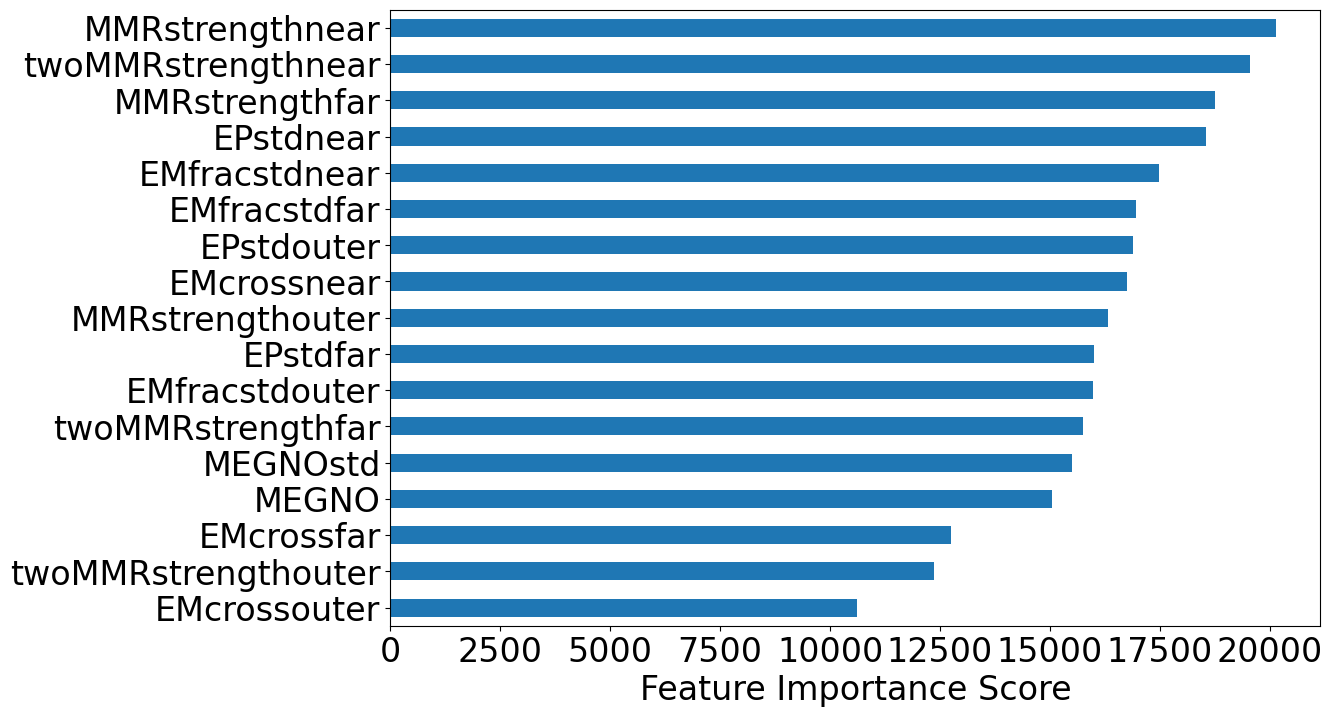

In [34]:
feat_imp = pd.Series(OuterModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

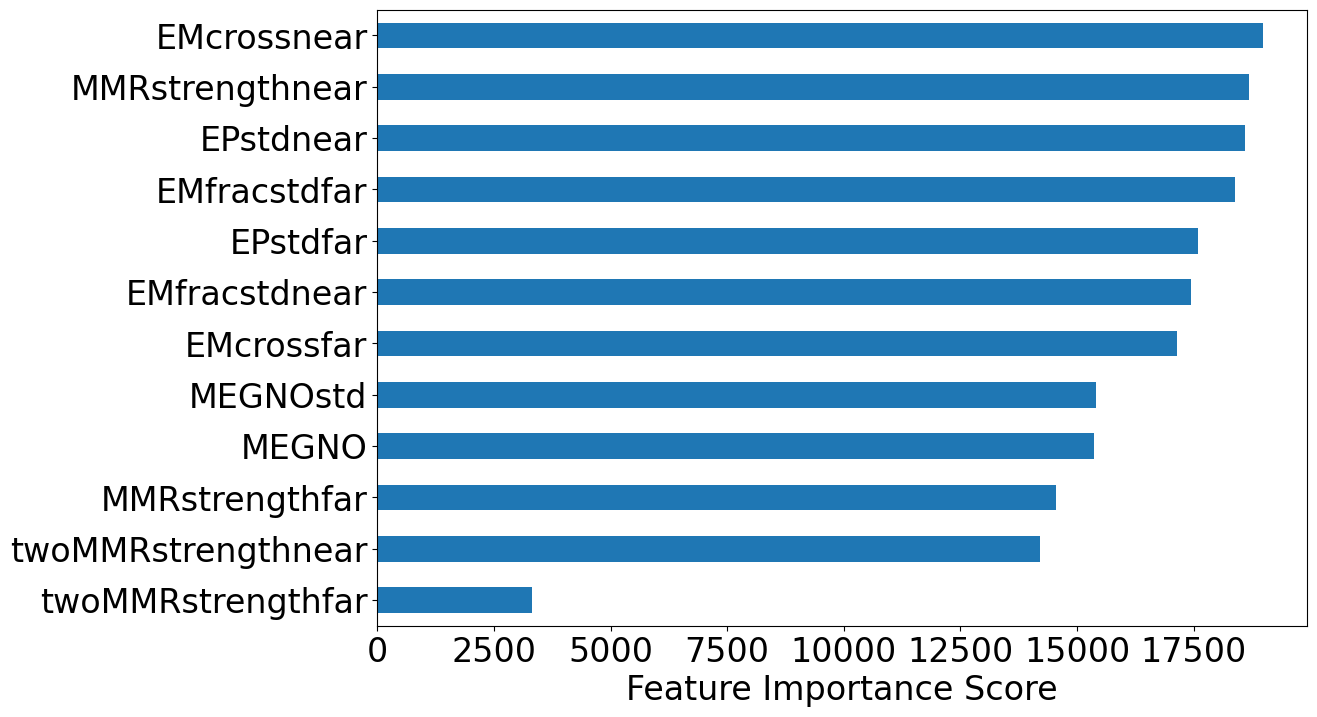

In [28]:
# feature importances
feat_imp = pd.Series(twoModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')